In [1]:
import pandas as pd 
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import shuffle
from scipy.sparse import lil_matrix, csr_matrix, save_npz, load_npz
from sortedcontainers import SortedList

from keras.models import Model
from keras.layers import Input, Embedding, Dot, Add, Flatten, Dense, Concatenate
from keras.layers import Dropout, BatchNormalization, Activation
from keras.regularizers import l2
from keras.optimizers import SGD, Adam


In [2]:
df=pd.read_csv('../data/edited_rating.csv')

In [3]:
N = df.User.max() + 1 # number of users
M = df.movie_idx.max() + 1 # number of movies
print(N,M)

6040 3706


# Split data 


In [4]:
# split into train and test
df = shuffle(df)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

# Model

In [5]:
# initialize variables
K = 10 # latent dimensionality
mu = df_train.Rating.mean() # global average 
epochs = 15

In [6]:
# keras model
u = Input(shape=(1,))
m = Input(shape=(1,))
u_embedding = Embedding(N, K)(u) # (N, 1, K)
m_embedding = Embedding(M, K)(m) # (N, 1, K)


##### main branch  -> MF  (linear model  )
u_bias = Embedding(N, 1)(u) # (N, 1, 1)
m_bias = Embedding(M, 1)(m) # (N, 1, 1)
x = Dot(axes=2)([u_embedding, m_embedding]) # (N, 1, 1)
x = Add()([x, u_bias, m_bias])
x = Flatten()(x) # (N, 1)


##### side branch  -> Residual branch  (to search for nonlinear pattern)
u_embedding = Flatten()(u_embedding) # (N, K)
m_embedding = Flatten()(m_embedding) # (N, K)
y = Concatenate()([u_embedding, m_embedding]) # (N, 2K)
y = Dense(400)(y)
y = Activation('elu')(y)
# y = Dropout(0.5)(y)
y = Dense(1)(y)


##### merge
x = Add()([x, y])

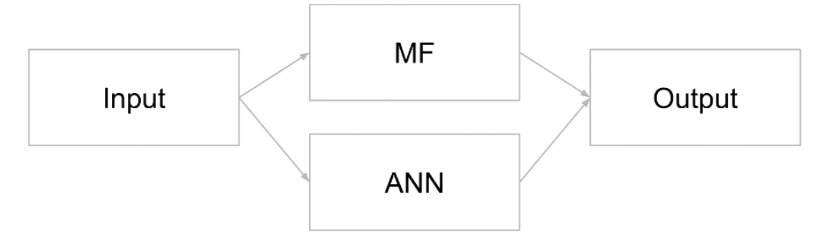

In [8]:
model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  optimizer=SGD(learning_rate=0.01, momentum=0.9),
  metrics=['mse'],
) # loss & metrics are mse -> will not be the same if we use regularization 

In [9]:
history = model.fit(
  x=[df_train.User.values, df_train.movie_idx.values],
  y=df_train.Rating.values - mu,
  epochs=15,
  batch_size=128,
  validation_data=(
    [df_test.User.values, df_test.movie_idx.values],
    df_test.Rating.values - mu
  )
)

Epoch 1/15
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 7s 931us/step - loss: 1.0142 - mse: 1.0142 - val_loss: 0.8427 - val_mse: 0.8427
Epoch 2/15
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 6s 917us/step - loss: 0.8363 - mse: 0.8363 - val_loss: 0.8303 - val_mse: 0.8303
Epoch 3/15
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 6s 925us/step - loss: 0.8229 - mse: 0.8229 - val_loss: 0.8260 - val_mse: 0.8260
Epoch 4/15
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 5s 859us/step - loss: 0.8194 - mse: 0.8194 - val_loss: 0.8224 - val_mse: 0.8224
Epoch 5/15
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 5s 853us/step - loss: 0.8129 - mse: 0.8129 - val_loss: 0.8303 - val_mse: 0.8303
Epoch 6/15
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 5s 836us/step - loss: 0.8078 - mse: 0.8078 - val_loss: 0.8106 - val_mse: 0.8106
Epoch 7/15
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 6s 888us/step - loss: 0.7970 - mse: 0.7970 - val_loss: 0.8019 - val_mse: 0.8019
Epoch 8/15
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 6s 873us/step - loss: 0.7891 - mse: 0.7891 - val_loss: 0.7981 - val_mse: 0.7981
Epoch 9/15
6252/6252 ━━━

#### no nonlinear pattern to be learnt

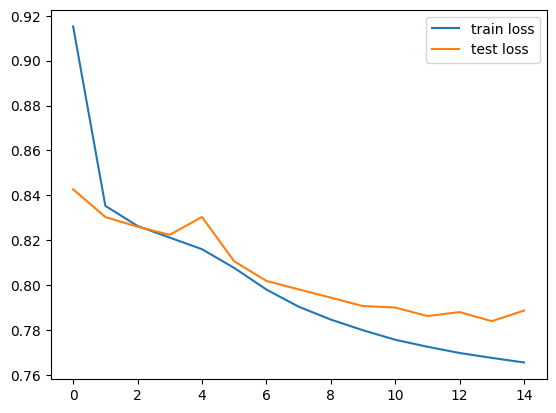

In [10]:
# plot losses
plt.plot(history.history['loss'], label="train loss")
plt.plot(history.history['val_loss'], label="test loss")
plt.legend()
plt.show()


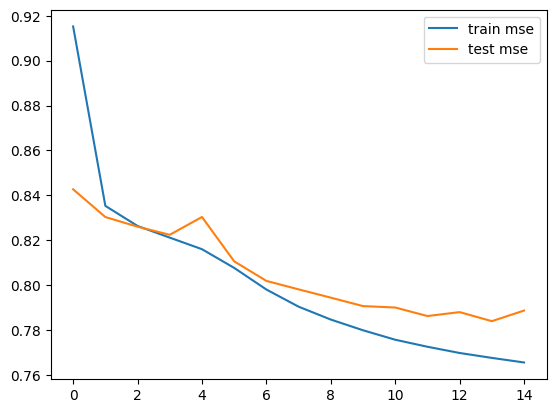

In [11]:
# plot mse
plt.plot(history.history['mse'], label="train mse")
plt.plot(history.history['val_mse'], label="test mse")
plt.legend()
plt.show()

In [12]:
model.save('MF_model_lin_res_ANN.h5') 

# single prediction 

In [13]:
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanSquaredError

In [14]:
model = load_model('MF_model_lin_res_ANN.h5', custom_objects={'mse': MeanSquaredError()})

with open('mu.pkl', 'rb') as f:
  mu = pickle.load(f)

In [15]:
def predict_single_rating(model, user_id, movie_id, mu):
    """
    Function to predict the rating for a specific user and movie.
    
    Parameters:
    - model: Trained Keras model
    - user_id: ID of the user (int)
    - movie_id: ID of the movie (int)
    - mu: Global mean rating (float)
    
    Returns:
    - final_predicted_rating: Predicted rating (float)
    """
    # Prepare inputs for the model (as arrays)
    user_input = np.array([user_id])  # Shape should be (1,)
    movie_input = np.array([movie_id])  # Shape should be (1,)

    # Predict the rating deviation from the mean
    predicted_rating = model.predict([user_input, movie_input])

    # Add the global mean rating back to the prediction
    final_predicted_rating = predicted_rating[0][0] + mu

    return final_predicted_rating

In [16]:
def existence(user_id , movie_id):
    rate=df[(df.User == user_id) & (df.movie_idx == movie_id)].Rating.values
    if len(rate)!=0:
            print(f"{(user_id, movie_id)} exists in the data with value : {rate[0]} ")
    else:
            print(f"{(user_id, movie_id)} does not exist in the data ")

In [17]:
print(predict_single_rating(model, 799, 100, mu))
existence(799, 100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
3.2283090800827394
(799, 100) does not exist in the data 


In [18]:
print(predict_single_rating(model, 1161, 1574, mu))
existence(1161  , 1574)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2.9180073589867006
(1161, 1574) exists in the data with value : 3 


In [19]:
print(predict_single_rating(model, 203, 3256, mu))
existence(203, 3256)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3.2512224764412294
(203, 3256) exists in the data with value : 3 
